Classes and amount of data:  {'Healthy': 283, 'Sick': 319}
Epoch [0], val_loss: 0.6717, val_acc: 0.4115
Epoch [1], val_loss: 0.6466, val_acc: 0.4062
Epoch [2], val_loss: 0.6168, val_acc: 0.5208
Epoch [3], val_loss: 0.6002, val_acc: 0.5938
Epoch [4], val_loss: 0.5671, val_acc: 0.7448
Epoch [5], val_loss: 0.5448, val_acc: 0.7812
Epoch [6], val_loss: 0.5509, val_acc: 0.6745
Epoch [7], val_loss: 0.5087, val_acc: 0.8125
Epoch [8], val_loss: 0.4866, val_acc: 0.8438
Epoch [9], val_loss: 0.4769, val_acc: 0.8385
Epoch [10], val_loss: 0.4637, val_acc: 0.8438
Epoch [11], val_loss: 0.4496, val_acc: 0.8594
Epoch [12], val_loss: 0.4319, val_acc: 0.8802
Epoch [13], val_loss: 0.4288, val_acc: 0.8672
Epoch [14], val_loss: 0.4316, val_acc: 0.8490
Epoch [15], val_loss: 0.4151, val_acc: 0.8724
Epoch [16], val_loss: 0.4249, val_acc: 0.8464
Epoch [17], val_loss: 0.3974, val_acc: 0.8750
Epoch [18], val_loss: 0.3970, val_acc: 0.8958
Epoch [19], val_loss: 0.3852, val_acc: 0.8958
Epoch [20], val_loss: 0.3775, v

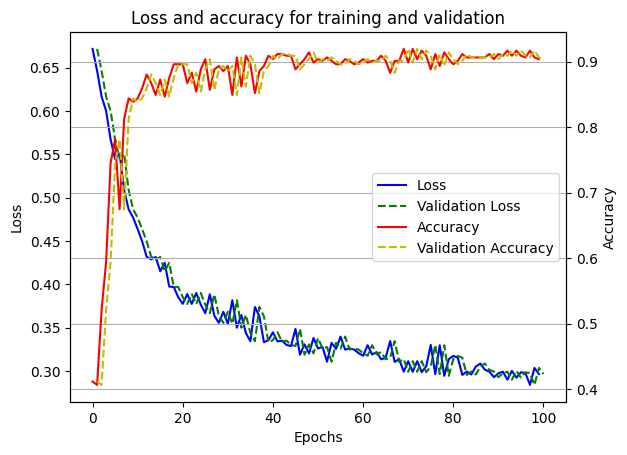

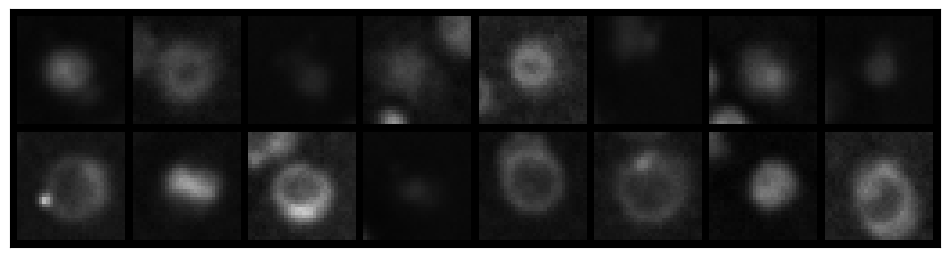

In [11]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose, Pad
from torch.utils.data import random_split, DataLoader
import torchvision.utils
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

# Use Apple Metal Performance Shaders (MPS) for GPU acceleration
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cpu')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# Define a custom transform that resizes and pads images to ensure they are 30x30 pixels
custom_transform = Compose([
    Resize((30, 30)),  # This resizes to 30x30 directly, assuming you're okay with potential distortion
    ToTensor()
])

# Load dataset with custom transform
dataset = ImageFolder('yeast-class', transform=custom_transform)

# dataset processing and loader setup
dataset_size = len(dataset)
classes = dataset.classes
num_classes = len(classes)
img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0

for i in range(dataset_size):
    img, label = dataset[i]
    img_dict[classes[label]] += 1

print("Classes and amount of data: ", img_dict)

# Set up data loaders
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Define paramters
num_epochs = 100
lr = 0.0001
opt_func = torch.optim.Adam


# Set up data loaders
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2, shuffle=True)

# Set up model
imput_size = 30 * 30 * 3
hidden_size = 64
num_classes = 2 # a cell can be either healthy or sick.

# Define accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define evaluation function
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Define traning function
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Define the model
class YeastModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        
    
# Instantiate the model and evaluate it
model = YeastModel(imput_size, hidden_size, num_classes)
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device);


history = fit(100, lr, model, train_loader, val_loader)

# Run on test data
test_loader = DataLoader(test_ds, batch_size)
result = evaluate(model, test_loader)
print("result from test batch: ", result)

# Plot loss- and validation loss for each epoch
tn = np.arange(1, len(history) + 1)
fig, ax1 = plt.subplots()
ax1.plot([x['val_loss'] for x in history], 'b', label="Loss")
ax1.plot(tn, [x['val_loss'] for x in history], '--', color='g', label="Validation Loss")
ax1.set_xlabel("Epochs"), ax1.set_ylabel("Loss")

# Plot accuracy- and validation accuracy for each epoch
ax2 = ax1.twinx()
ax2.plot([x['val_acc'] for x in history], 'r', label="Accuracy")
ax2.plot(tn, [x['val_acc'] for x in history], '--', color='y', label="Validation Accuracy")
ax2.set_ylabel("Accuracy")
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines+lines2, labels+labels2, loc='right')
plt.grid()
plt.title('Loss and accuracy for training and validation')
plt.savefig("Loss and accuracy.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Print images used in the training
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(images, nrow=8).permute(1, 2, 0))
    break



In [12]:
# Save the model
# Define the key for the model based on the hyperparameters
key = "linear" + batch_size.__str__() + "_" + num_epochs.__str__() + "_" + lr.__str__() + "_" + opt_func.__name__
torch.save(model.state_dict(), f"models/{key}.pth")